# ETL
*Extract-transform-load*

This notebook does the data engineering steps required for the Met-ML training and evaluation:

- load fluxnet csvs
- fit transformers on the full dataset
- saves the preprocessed data and transformers for use in the next steps of the project

In [1]:
%load_ext lab_black

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [110]:
import intake
import pandas as pd
import numpy as np
import xarray as xr

from tqdm import tqdm
from joblib import dump

from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from dask.distributed import Client


from met_ml.train.fluxnet_etl import load_fluxnet, get_meta, make_lookback
from met_ml.train.models import fit_transformers, transform_df


lookback = 90
train_vars = ["P", "t_min", "t_max", "t", "lat", "elev"]
target_vars = ["SW_IN_F", "LW_IN_F", "PA_F", "RH"]

In [3]:
client = Client(n_workers=24)
client

Client Scheduler: tcp://127.0.0.1:33961 Dashboard: proxy/8787/status,Cluster Workers: 24 Cores: 24 Memory: 85.90 GB


In [4]:
cat = intake.Catalog("../data/fluxnet/catalog.yml")
all_site_meta = pd.read_excel("../data/fluxnet/FLX_AA-Flx_BIF_LATEST.xlsx").set_index(
    ["SITE_ID", "VARIABLE"]
)["DATAVALUE"]

all_site_meta.head()

SITE_ID  VARIABLE            
AR-SLu   MAP                                      400
         COUNTRY                            Argentina
         DOI                     10.18140/FLX/1440191
         DOI_DATAPRODUCT                  FLUXNET2015
         DOI_CONTRIBUTOR_NAME       Patricio Magliano
Name: DATAVALUE, dtype: object

In [5]:
df = load_fluxnet(cat, all_site_meta)

In [6]:
df.count()

P          548611
t_min      548611
t_max      548611
SW_IN_F    548611
LW_IN_F    548611
PA_F       548611
RH         461858
t          548611
lat        548611
elev       548611
dtype: int64

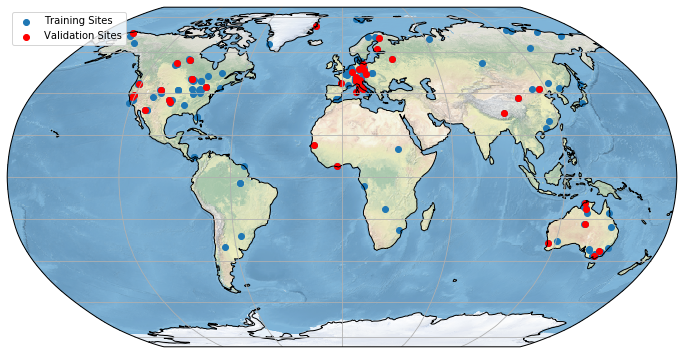

In [7]:
all_sites = all_site_meta.index.get_level_values(0).unique()
meta = get_meta(all_site_meta)
meta = pd.DataFrame.from_dict(meta, orient="index")
test_meta = meta.sort_values(["lat"])[::5]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax.scatter(meta.lon, meta.lat, transform=ccrs.PlateCarree(), label="Training Sites")
ax.scatter(
    test_meta.lon,
    test_meta.lat,
    c="r",
    transform=ccrs.PlateCarree(),
    label="Validation Sites",
)
ax.set_global()
ax.stock_img()
ax.coastlines()
ax.gridlines()
ax.legend()

In [8]:
df.head()

P   t_min   t_max     SW_IN_F     LW_IN_F  \
       TIMESTAMP_START                                                
AR-SLu 2009-01-01       0.0  18.632  23.105   79.239667  380.892000   
       2009-01-02       0.0  17.421  26.319  254.912292  369.231500   
       2009-01-03       0.0  16.709  30.400  342.819187  346.828625   
       2009-01-04       0.0  20.551  33.735  410.918083  338.023500   
       2009-01-05       0.0  21.835  32.551  306.377375  367.396125   

                             PA_F  RH  t      lat   elev  
       TIMESTAMP_START                                    
AR-SLu 2009-01-01       95.294625 NaN  1 -33.4648  508.0  
       2009-01-02       95.597354 NaN  2 -33.4648  508.0  
       2009-01-03       95.650583 NaN  3 -33.4648  508.0  
       2009-01-04       95.272437 NaN  4 -33.4648  508.0  
       2009-01-05       94.955813 NaN  5 -33.4648  508.0

In [114]:
def split_by_meta(df, keys, test_keys):
    train = []
    val = []

    for key in keys:
        if key in test_keys:
            val.append(df.loc[key])
        else:
            train.append(df.loc[key])
    return train, val


def qc(da):
    if da.isnull().sum() > 0:
        print("nans found")


# split the data into train/val groups
# x_train, x_val, y_train, y_val = split(x_data_computed, y_data_computed)
train, val = split_by_meta(df, meta.index.to_list(), test_meta.index.to_list())


# fit the transformers
trans = fit_transformers(train)
# x_trans = subset_columntransformer(trans.transformers, trainl


# create the 3D tensor for the LSTM including a lookback dimension
for name, df_list in zip(["train", "val"], [train, val]):
    da = xr.concat(
        [make_lookback(transform_df(trans, d), lookback=lookback) for d in df_list],
        dim="samples",
    )
    da.name = name
    print(name, da.shape)
    qc(da)

    # save x data
    #     print(da.sel(features=train_vars))
    da.sel(features=train_vars).to_netcdf(f"../data/etl/x_{name}.nc")

    # save y data
    #     print(da.sel(features=target_vars).isel(lookback=-1))
    da.sel(features=target_vars).isel(lookback=-1).to_netcdf(f"../data/etl/y_{name}.nc")

train (274136, 90, 10)
val (63528, 90, 10)


P
t_min
t_max
t
lat
elev
SW_IN_F
LW_IN_F
PA_F
RH


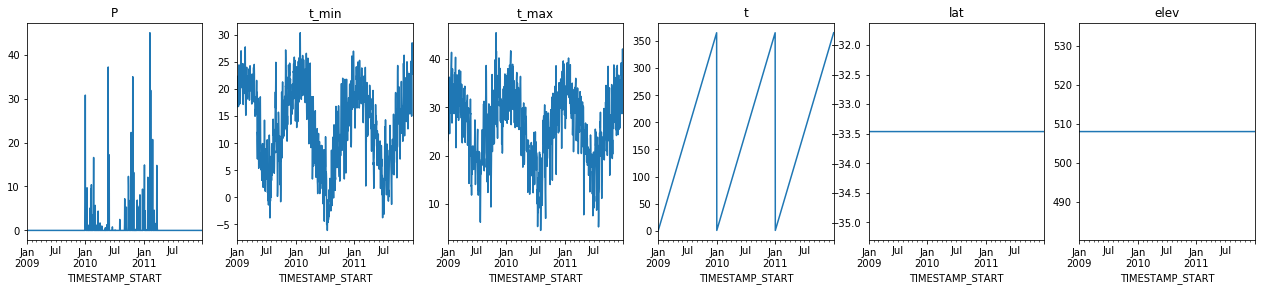

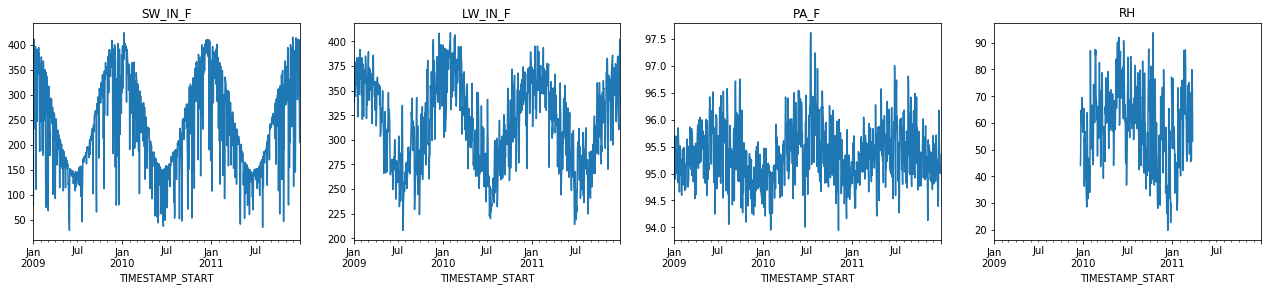

In [115]:
def plot_vars(df):
    fig, axes = plt.subplots(
        ncols=len(df.columns), nrows=1, sharex=True, figsize=(22, 4)
    )

    for ax, (key, s) in zip(axes, df.items()):
        print(key)
        s.plot(ax=ax)
        ax.set_title(key)


d = train[0]
plot_vars(d[train_vars])
plot_vars(d[target_vars])

P
t_min
t_max
t
lat
elev
SW_IN_F
LW_IN_F
PA_F
RH


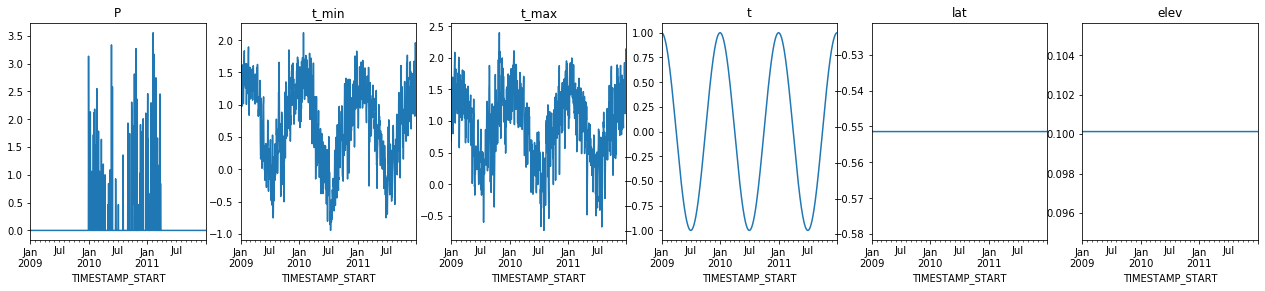

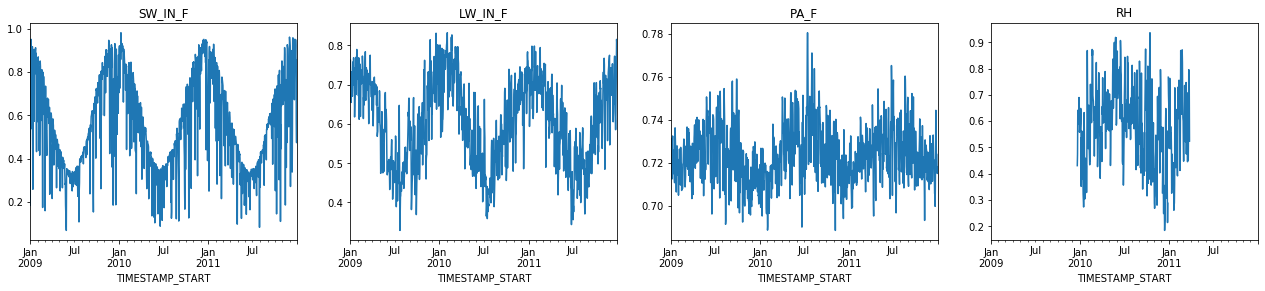

In [117]:
td = transform_df(trans, d)
plot_vars(td[train_vars])
plot_vars(td[target_vars])

In [118]:
# TODO: use ONNX for this
dump(trans, "../data/etl/fluxnet_all_transformers.joblib")  # save for later

['../data/etl/fluxnet_all_transformers.joblib']

In [119]:
df.to_csv("../data/etl/fluxnet.csv")
df.head()

P   t_min   t_max     SW_IN_F     LW_IN_F  \
       TIMESTAMP_START                                                
AR-SLu 2009-01-01       0.0  18.632  23.105   79.239667  380.892000   
       2009-01-02       0.0  17.421  26.319  254.912292  369.231500   
       2009-01-03       0.0  16.709  30.400  342.819187  346.828625   
       2009-01-04       0.0  20.551  33.735  410.918083  338.023500   
       2009-01-05       0.0  21.835  32.551  306.377375  367.396125   

                             PA_F  RH  t      lat   elev  
       TIMESTAMP_START                                    
AR-SLu 2009-01-01       95.294625 NaN  1 -33.4648  508.0  
       2009-01-02       95.597354 NaN  2 -33.4648  508.0  
       2009-01-03       95.650583 NaN  3 -33.4648  508.0  
       2009-01-04       95.272437 NaN  4 -33.4648  508.0  
       2009-01-05       94.955813 NaN  5 -33.4648  508.0

In [120]:
meta.to_csv("../data/etl/meta.csv")
meta.head()

,lat,lon,elev
AR-SLu,-33.46480,-66.4598,508.0
AR-Vir,-28.23950,-56.1886,105.0
AT-Neu,47.11667,11.3175,970.0
AU-Ade,-13.07690,131.1178,76.0
AU-ASM,-22.28300,133.2490,606.0


In [121]:
test_meta.to_csv("../data/etl/test_meta.csv")
test_meta.head()

,lat,lon,elev
AU-Wac,-37.4259,145.1878,753.0
AU-Ync,-34.9893,146.2907,126.0
AU-Gin,-31.3764,115.7138,51.0
AU-TTE,-22.2870,133.6400,552.0
AU-Dry,-15.2588,132.3706,176.0


In [122]:
trans

{'P': FunctionTransformer(accept_sparse=False, check_inverse=True,
                     func=<ufunc 'cbrt'>, inv_kw_args=None, inverse_func=None,
                     kw_args=None, pass_y='deprecated', validate=False),
 't_min': StandardScaler(copy=True, with_mean=True, with_std=True),
 't_max': StandardScaler(copy=True, with_mean=True, with_std=True),
 'SW_IN_F': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'LW_IN_F': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'PA_F': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'RH': MinMaxScaler(copy=True, feature_range=(0, 1)),
 't': FunctionTransformer(accept_sparse=False, check_inverse=True,
                     func=<function day_of_year_scaler at 0x2b5a0131dc80>,
                     inv_kw_args=None, inverse_func=None, kw_args=None,
                     pass_y='deprecated', validate=False),
 'lat': FunctionTransformer(accept_sparse=False, check_inverse=True,
                     func=<function latitude_scaler at 0x2b59f6ca3a60>,
   

In [18]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow import keras

# A1 = Input(shape=(30,),name='A1')
# A2 = Dense(8, activation='relu',name='A2')(A1)
# A3 = Dense(30, activation='relu',name='A3')(A2)

# B2 = Dense(40, activation='relu',name='B2')(A2)
# B3 = Dense(30, activation='relu',name='B3')(B2)

# merged = Model(inputs=[A1],outputs=[A3,B3])
# plot_model(merged,to_file='demo.png',show_shapes=True)

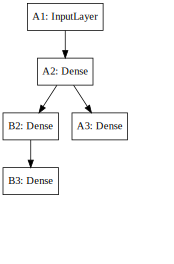

In [3]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

SVG(model_to_dot(merged).create(prog='dot', format='svg'))

In [13]:
xdims = {'samples': 274136, 'lookback': 90, 'features': 6}
ydims = {'samples': 274136, 'features': 1}
input_shape = (xdims["lookback"], xdims["features"])


def make_met_model(var, ydims=None):
    # design network
    name = f"1_layer_met_model_{var}"
    model = Sequential(name=name)
    model.add(LSTM(20, input_shape=input_shape, use_bias=True))
    model.add(Dense(ydims["features"]))
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model

def make_streamflow_model(input_shape, yfeatures):
    # design network
    name = "streamflow".format(nvars=input_shape[1])
    model = Sequential(name=name)
    model.add(LSTM(20, input_shape=input_shape, use_bias=True))
    model.add(Dense(yfeatures))
    model.compile(loss='mean_squared_error', optimizer="adam")
    return model



In [40]:
[all_met_lstms.values()]

AttributeError: 'Tensor' object has no attribute 'values'

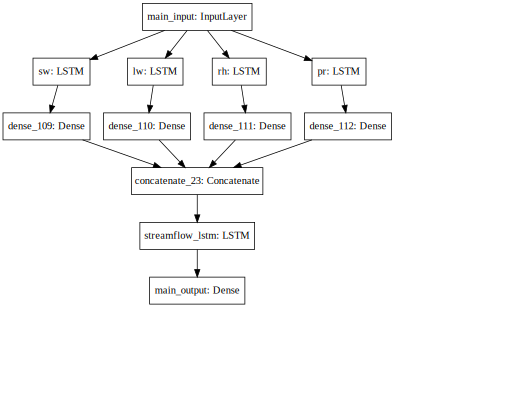

In [51]:
in_vars = ['pcp', 'tmax', 'tmin']
met_vars = ['sw', 'lw', 'rh', 'pr']
lookback = 365

main_input = Input(shape=(lookback, len(in_vars)), dtype='float32', name='main_input')

# met layers
met_lstms = {k: LSTM(20, use_bias=True, name=k, return_sequences=True)(main_input) for k in met_vars}
dense_lstms = {k: Dense(1)(met_lstms[k]) for k in met_vars}

all_met = keras.layers.concatenate([*dense_lstms.values()])

# streamflow layers
qlstm = LSTM(20, use_bias=True, name='streamflow_lstm')(all_met)
main_output = Dense(1, name='main_output')(qlstm)

model = Model(inputs=[main_input], outputs=[main_output])

SVG(model_to_dot(model).create(prog='dot', format='svg'))

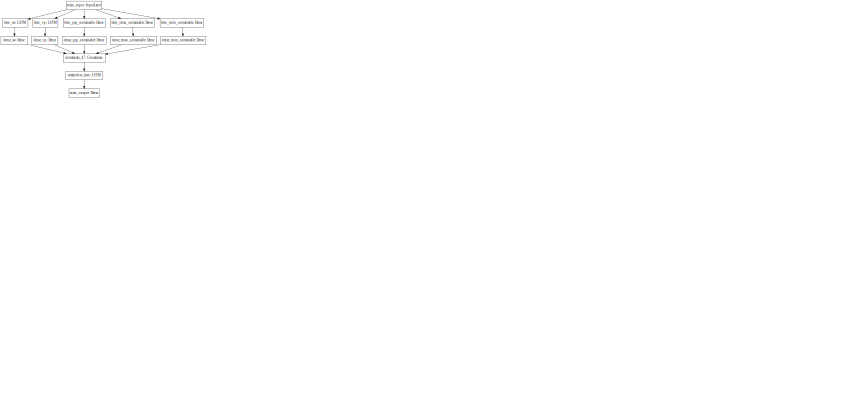

In [124]:
in_vars = ['pcp', 'tmax', 'tmin']
met_vars = ['sw', 'vp']
lookback = 365

main_input = Input(shape=(lookback, len(in_vars) ), dtype='float32', name='main_input')

# met layers
met_lstms = {k: LSTM(20, use_bias=True, name=f'lstm_{k}', return_sequences=True)(main_input) for k in met_vars}
dense_lstms = {k: Dense(1, name=f'dense_{k}')(m) for k, m in met_lstms.items()}

# This is a hack because I can't figure out how to pass forcings through any other way
for k in in_vars:
    met_lstms[k] = Dense(1, name=f'lstm_{k}_untrainable', kernel_initializer='ones')(main_input)
    dense_lstms[k] = Dense(1, name=f'dense_{k}_untrainable', kernel_initializer='ones')(met_lstms[k])

all_met = keras.layers.concatenate([*dense_lstms.values()])

# streamflow layers
qlstm = LSTM(20, use_bias=True, name='streamflow_lstm')(all_met)
main_output = Dense(1, name='main_output')(qlstm)

model = Model(inputs=[main_input], outputs=[main_output], name='dag_lstm')

for m in in_vars:
    model.get_layer(f'lstm_{k}_untrainable').trainable = False
    model.get_layer(f'dense_{k}_untrainable').trainable = False

d = model_to_dot(model, dpi=300)
d.write_png('dag_lstm.png')
svg = d.create(prog='dot', format='svg', )
SVG(svg)

In [122]:
model.summary()

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 365, 3)]     0                                            
__________________________________________________________________________________________________
lstm_sw (LSTM)                  (None, 365, 20)      1920        main_input[0][0]                 
__________________________________________________________________________________________________
lstm_vp (LSTM)                  (None, 365, 20)      1920        main_input[0][0]                 
__________________________________________________________________________________________________
lstm_pcp_untrainable (Dense)    (None, 365, 1)       4           main_input[0][0]                 
___________________________________________________________________________________________

In [117]:
model.compile(loss='mean_squared_error', optimizer="adam")
model.get_layer('lstm_tmin_untrainable').bias

<tf.Variable 'lstm_tmin_untrainable_4/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>

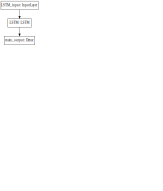

In [76]:
in_vars = ['pcp', 'tmax', 'tmin']
all_vars = ['sw', 'vp'] + in_vars
lookback = 365

model = Sequential(name='SequentialLSTM')
model.add(LSTM(20, input_shape=input_shape, use_bias=True, name='LSTM'))
model.add(Dense(5, name='main_output'))
d = model_to_dot(model, dpi=300)
d.write_png('sequential_lstm.png')
svg = d.create(prog='dot', format='svg', )
SVG(svg)

In [103]:
model.get_layer('vp').trainable = False

In [ ]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model


def make_model_1(input_shape, yfeatures):
    # design network
    name = "1_layer_lstm_{nvars}".format(nvars=input_shape[1])
    model = Sequential(name=name)
    model.add(LSTM(20, input_shape=input_shape, use_bias=True))
    model.add(Dense(yfeatures))
    model.compile(loss='mean_squared_error', optimizer="adam", metrics=metrics)
    return model


def make_model_2(input_shape, yfeatures):
    in_vars = ['pcp', 'tmax', 'tmin']
    met_vars = ['sw', 'lw', 'rh', 'pr'] 
    main_input = Input(shape=input_shape, dtype='float32', name='main_input')

    # met layers
    met_lstms = {k: LSTM(20, use_bias=True, name=f'lstm_{k}', return_sequences=True)(main_input) for k in met_vars}
    dense_lstms = {k: Dense(1, name=f'dense_{k}')(m) for k, m in met_lstms.items()}

    # This is a hack because I can't figure out how to pass forcings through any other way
    for k in in_vars:
        met_lstms[k] = Dense(1, name=f'lstm_{k}_untrainable', kernel_initializer='ones')(main_input)
        dense_lstms[k] = Dense(1, name=f'dense_{k}_untrainable', kernel_initializer='ones')(met_lstms[k])

    all_met = keras.layers.concatenate([*dense_lstms.values()])

    # streamflow layers
    qlstm = LSTM(20, use_bias=True, name='streamflow_lstm')(all_met)
    main_output = Dense(yfeatures, name='main_output')(qlstm)

    model = Model(inputs=[main_input], outputs=[main_output], name='dag_lstm')

    for m in in_vars:
        model.get_layer(f'lstm_{k}_untrainable').trainable = False
        model.get_layer(f'dense_{k}_untrainable').trainable = False
    model.compile(loss='mean_squared_error', optimizer="adam", metrics=metrics)
    return model

In [ ]:


batch_size = 512
history = {}


def make_callbacks(name):
    mc = ModelCheckpoint(
        f"best_{name}.h5",
        monitor="val_nse",
        mode="max",
        verbose=0,
        save_best_only=True,
    )
    es = EarlyStopping(monitor="val_nse", mode="max", verbose=0, patience=30)
    return [es, mc]


model_inputs = [
    (['prcp(mm/day)', 'srad(W/m2)', 'tmax(C)', 'tmin(C)', 'vp(Pa)'], [make_model_1]),
    (['prcp(mm/day)', 'tmax(C)', 'tmin(C)'], [make_model_1, make_model_2]),
]

for inputs, constructors in model_inputs:

    xtrain = train_da.sel(features=inputs).values
    ytrain = train_da.sel(features=target_vars).isel(lookback=-1).values
    
    xval = val_da.sel(features=inputs).values
    yval = val_da.sel(features=target_vars).isel(lookback=-1).values
       
    input_shape = (len(train_da.lookback), len(inputs))
    
    print(input_shape)

    for 
    model = make_model_2(input_shape, 1)
#     model.summary()
#     history[model.name] = model.fit(
#         xtrain, ytrain,
#         validation_data=(xval, yval),
#         batch_size=batch_size,
#         epochs=25,
#         shuffle=True,
#         verbose=0,
#         callbacks=make_callbacks(model.name),
#     )